# Shor Algorithm:

We follow the steps and gates names as in "A General Implementation of Shor’s Algorithm":

- https://medium.com/mit-6-s089-intro-to-quantum-computing/a-general-implementation-of-shors-algorithm-da1595694430

In [38]:
# Import the required modules
import os
from dotenv import load_dotenv

from qiskit.circuit import QuantumCircuit
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister, AncillaRegister
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import HGate, CCXGate, RZGate, CPhaseGate
from matplotlib import pyplot as plt

import QuantumRingsLib
from QuantumRingsLib import QuantumRingsProvider
from quantumrings.toolkit.qiskit import QrBackendV2
from quantumrings.toolkit.qiskit import QrJobV1


from matplotlib import pyplot as plt
import math
import numpy as np

In [2]:
# Load environment variables from .env file
load_dotenv()

token = os.getenv("QUANTUM_RINGS_TOKEN")
name = os.getenv("QUANTUM_RINGS_NAME")

provider = QuantumRingsProvider(
    token=token,
    name=name
)
backend = provider.get_backend("scarlet_quantum_rings")
shots = 1024

provider.active_account()

{'name': 'cffuidio@gmail.com',
 'token': 'rings-200.t2iD6huiMZ4DMUowJyfZFMiW3cGGrqF6',
 'max_qubits': '200'}

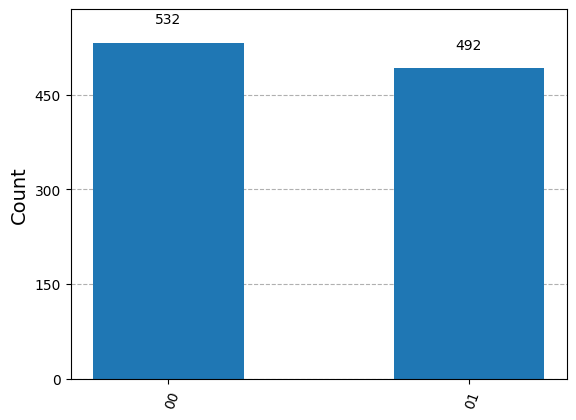

In [ ]:
# Example of running a qiskit circuit with quantum rings backend
numberofqubits = 2
shots = 1024

q = QuantumRegister(numberofqubits , 'q')
qc = QuantumCircuit(q)
qc.h(0)

qc.measure_all()


# Execute the quantum code
mybackend = QrBackendV2(property, num_qubits = qc.num_qubits)
qc_transpiled = transpile(qc, mybackend, initial_layout=[i for i in range(0, qc.num_qubits)])
job = mybackend.run(qc_transpiled, shots = shots)

result = job.result()
counts = result.get_counts()
plot_histogram(counts)


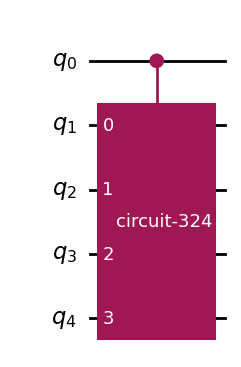

In [57]:
# Constructions of gates:
CHGate = HGate().control(1) # Control H
CCCXGate = CCXGate().control(1)
CCPhase = CPhaseGate(1).control(1) # Add control
CCRZGate = RZGate(1).control(2)

qc = QuantumCircuit(4)

qc.append(CCCXGate, [0, 2, 3, 1])
qc.append(CHGate, [1, 0]) # First is the contorl
qc.append(CCPhase, [1, 0, 2])
qc.cswap(0, 1, 2)
qc.cx(0, 1)
qc.ccx(0, 1, 2)

qc.append(CCRZGate, [0, 1, 2])

QCGate = qc.to_gate().control(1)

qc_new = QuantumCircuit(5)

qc_new.append(QCGate, [0, 1, 2, 3, 4])


qc_new.draw("mpl") # Last is the control

In [104]:
def iqft_cct(qc, b, qubit_list):
    """
    The inverse QFT circuit

    Args:

        qc (QuantumCircuit):
                The quantum circuit

        b (QuantumRegister):
                The target register

        qubit_list (int[]):
                List of qubits where the IQFT is applied

    Returns:
        None

    """

    n = len(qubit_list)

    for i in range (n):
        for j in range (1, i+1):
            # for inverse transform, we have to use negative angles
            qc.cp(  -math.pi / 2** ( i -j + 1 ), b[qubit_list[j - 1]], b[qubit_list[i]])

            # qc.cu1( -math.pi / 2** ( i -j + 1 ), b[qubit_list[j - 1]], b[qubit_list[i]] )
        # the H transform should be done after the rotations
        qc.h(b[qubit_list[i]])
    # qc.barrier()
    return


def control_iqft_cct(qc, b, qubit_list, control):
    """
    The inverse QFT circuit contrlled by control

    Args:

        qc (QuantumCircuit):
                The quantum circuit

        b (QuantumRegister):
                The target register

        qubit list (int[]):
                List of qubits where the control QFT is applied

        control (int):
                control qubit

    Returns:
        None

    """

    n = len(qubit_list)

    for i in range (n):
        for j in range (1, i+1):
            # for inverse transform, we have to use negative angles
            phase = -math.pi / 2** ( i -j + 1 )
            CCPhase = CPhaseGate( phase ).control(1) # Add control
            qc.append(CCPhase, [ control, b[qubit_list[j - 1]], b[qubit_list[i]]   ])


        # the H transform should be done after the rotations
        qc.append(CHGate, [ control , b[qubit_list[i]] ])
        
    # qc.barrier()
    return





def qft_cct(qc, b, qubit_list):
    """
    The QFT circuit

    Args:

        qc (QuantumCircuit):
                The quantum circuit

        b (QuantumRegister):
                The target register

        qubit_list (int[]):
                The number of qubits in the registers to use

    Returns:
        None

    """

    n = len(qubit_list)

    for i in range (n):
    
        qc.h(b[qubit_list[i]])
        for j in range (i+1, n):
            # qc.cu1( math.pi / 2**(i - j + 1), b[qubit_list[j]], b[qubit_list[i]]  )
            qc.cp( math.pi / 2**(i - j + 1), b[qubit_list[j]], b[qubit_list[i]]  )


    # qc.barrier()

    for i in range(int(n/2)):
        qc.swap(b[qubit_list[i]], b[qubit_list[(n-1)-i]])

    # qc.barrier()


    return



def control_qft_cct(qc, b, qubit_list, control):
    """
    The QFT circuit

    Args:

        qc (QuantumCircuit):
                The quantum circuit

        b (QuantumRegister):
                The target register

        qubit_list (int[]):
                Qubits where the QFT is applied

        control (int):
                Qubit control

    Returns:
        None

    """

    n = len(qubit_list)

    for i in range (n):
    


        qc.append(CHGate, [ control , b[qubit_list[i]] ])
        for j in range (i+1, n):

            phase = math.pi / 2** ( i -j + 1 )
            CCPhase = CPhaseGate( phase ).control(1) # Add control
            qc.append(CCPhase, [ control, b[qubit_list[j]], b[qubit_list[i]]   ])


    # qc.barrier()

    for i in range(int(n/2)):
        qc.cswap(control, b[qubit_list[i]], b[qubit_list[(n-1)-i]]) # Add control swap

    # qc.barrier()


    return




def adder_gate(qc, b, qubit_list, a):
    """
    The adder circuit

    Args:

        qc (QuantumCircuit):
                The quantum circuit

        b (QuantumRegister):
                The target register

        qubit_list (int[]):
                number of qubits to use

        a (float):
                Parameter

    Returns:
        None

    """


    n = len(qubit_list)

    for i in range(n):
        exponent = (n - i)
        qc.rz( 2 * math.pi * a / (2**(exponent)), b[qubit_list[i]])

    # qc.barrier()

    return


def substract_gate(qc, b, qubit_list, a):
    """
    The inverse of adder circuit

    Args:

        qc (QuantumCircuit):
                The quantum circuit

        b (QuantumRegister):
                The target register

        qubit_list (int[]):
                number of qubits to use

        a (float):
                Parameter

    Returns:
        None

    """

    # Inverse of adder gate:

    n = len(qubit_list)

    for i in range(n):
        exponent = (n - i)
        qc.rz( - 2 * math.pi * a / (2**(exponent)), b[qubit_list[i]]) # Only change sign

    # qc.barrier()

    return


def control_adder_gate(qc, b, qubit_list, a, control):
    """
    Control adder gate

    Args:

        qc (QuantumCircuit):
                The quantum circuit

        b (QuantumRegister):
                The target register

        qubit_list (int[]):
                number of qubits to use

        a (float):
                Parameter

        control (int):
                Control qubit number

    Returns:
        None

    """

    n = len(qubit_list)

    for i in range(n):
        exponent = (n - i)
        qc.crz( 2 * math.pi * a / (2**(exponent)), control, b[qubit_list[i]])

    # qc.barrier()

    return


def control_substract_gate(qc, b, qubit_list, a, control):
    """
    The inverse of adder circuit

    Args:

        qc (QuantumCircuit):
                The quantum circuit

        b (QuantumRegister):
                The target register

        qubit_list (int[]):
                number of qubits to use

        a (float):
                Parameter

    Returns:
        None

    """

    # Inverse of adder gate:

    n = len(qubit_list)

    for i in range(n):
        exponent = (n - i)
        qc.crz( - 2 * math.pi * a / (2**(exponent)), control, b[qubit_list[i]]) # Only change sign

    # qc.barrier()

    return


def control_control_adder_gate(qc, b, qubit_list, a, control1, control2):
    """
    Control adder gate

    Args:

        qc (QuantumCircuit):
                The quantum circuit

        b (QuantumRegister):
                The target register

        qubit_list (int[]):
                number of qubits to use

        a (float):
                Parameter

        control (int):
                Control qubit number

    Returns:
        None

    """

    n = len(qubit_list)

    for i in range(n):
        exponent = (n - i)
        phase = 2 * math.pi * a / (2**(exponent))
        CCRZGate = RZGate(1).control(2)
        qc.append(CCRZGate, [control2, control1, b[qubit_list[i]]])

    # qc.barrier()

    return



def modular_adder(qc, b, qubit_list, a, N, ancilla_QFT, ancilla):
    """
    Modular adder gate

    Args:

        qc (QuantumCircuit):
                The quantum circuit

        b (QuantumRegister):
                The target register

        qubit_list (int[]):
                number of qubits to use

        a (float):
                Parameter

        N (int):
                Parameter representing the mod (mod N)

        ancilla_QFT (int):
                Number of the ancilla qubit used for QFT (see paper)

        ancilla (int):
                Number of the ancilla qubit

    Returns:
        None

    """

    qft_list = qubit_list
    qft_list.append(ancilla_QFT)

    adder_gate(qc, b, qubit_list, a)
    substract_gate(qc, b, qubit_list, N)

    iqft_cct(qc, b, qft_list) # Use QFT to
    qc.cx(ancilla_QFT, ancilla)
    qft_cct(qc, b, qft_list)

    control_adder_gate(qc, b, qubit_list, N, ancilla)
    substract_gate(qc, b, qubit_list, a)


    iqft_cct(qc, b, qft_list) # Use QFT to
    qc.x(ancilla_QFT)
    qc.cx(ancilla_QFT, ancilla)
    qc.x(ancilla_QFT)
    qft_cct(qc, b, qft_list)


    adder_gate(qc, b, qubit_list, a)

    return


# Finish this
def control_modular_adder(qc, b, qubit_list, a, N, ancilla_QFT, ancilla, control):
    """
    Control Modular adder gate

    Args:

        qc (QuantumCircuit):
                The quantum circuit

        b (QuantumRegister):
                The target register

        qubit_list (int[]):
                number of qubits to use

        a (float):
                Parameter

        N (int):
                Parameter representing the mod (mod N)

        ancilla_QFT (int):
                Number of the ancilla qubit used for QFT

        ancilla (int):
                Number of the ancilla qubit

        control (int):
                Number of control qubit

    Returns:
        None

    """

    qft_list = qubit_list.copy()
    qft_list.append(ancilla_QFT)

    control_adder_gate(qc, b, qubit_list, a, control)
    control_substract_gate(qc, b, qubit_list, N, control)


    control_iqft_cct(qc, b, qft_list, control) # Use QFT to
    qc.ccx(control, ancilla_QFT, ancilla) 
    control_qft_cct(qc, b, qft_list, control)

    control_control_adder_gate(qc, b, qubit_list, N, ancilla, control) ## Add another control here
    control_substract_gate(qc, b, qubit_list, a, control)


    control_iqft_cct(qc, b, qft_list, control) # Use QFT to
    qc.cx(control, ancilla_QFT)
    qc.ccx(control, ancilla_QFT, ancilla)
    qc.cx(control, ancilla_QFT)
    control_qft_cct(qc, b, qft_list, control)


    control_adder_gate(qc, b, qubit_list, a, control)

    return


# Finish this
def control_control_modular_adder(qc, b, qubit_list, a, N, ancilla_QFT, ancilla, control1, control2):
    """
    Control Modular adder gate

    Args:

        qc (QuantumCircuit):
                The quantum circuit

        b (QuantumRegister):
                The target register

        qubit_list (int[]):
                number of qubits to use

        a (float):
                Parameter

        N (int):
                Parameter representing the mod (mod N)

        ancilla_QFT (int):
                Number of the ancilla qubit used for QFT

        ancilla (int):
                Number of the ancilla qubit

        control (int):
                Number of control qubit

    Returns:
        None

    """

    n = len(qubit_list)
    qubit_list_new = [i for i in range(len(qubit_list))]
    ancilla_QFT_new = n
    ancilla_new = n + 1
    control1_new = n+2
    

    b_new = QuantumRegister(n + 3)
    qc_new = QuantumCircuit(b_new) # The first three controls

    control_modular_adder(qc_new, b_new, qubit_list_new, a, N, ancilla_QFT_new, ancilla_new, control1_new)
    
    U = qc_new.to_gate().control(1)

    q_list = qubit_list.copy()
    q_list.append(ancilla_QFT)
    q_list.append(ancilla)
    q_list.append(control1)

    q_list = [control2] + q_list 


    qc.append(U, q_list)

    return



def multiplier_gate(qc, b, qubit_list, a, N, x_qubit_list, ancilla_QFT, ancilla): # We have to do the control multiplier and the control swap.
    # For finish the control multiplier we have to finish the control_modular_adder

    """
    Multiplier gate

    Args:

        qc (QuantumCircuit):
                The quantum circuit

        b (QuantumRegister):
                The target register

        qubit_list (int[]):
                number of qubits to use

        a (float):
                Parameter

        N (int):
                Parameter representing the mod (mod N)

        x_qubit_list (int[])
                List of qubits in x register

        ancilla_QFT (int):
                Number of the ancilla qubit used for QFT

        ancilla (int):
                Number of the ancilla qubit

        control (int):
                Number of control qubit

    Returns:
        None

    """

    n = len(qubit_list)
    m = len(x_qubit_list)

    qft_cct(qc, b, qubit_list)


    for i in range(m):
        control_modular_adder(qc, b, qubit_list, a * 2**i, N, ancilla_QFT, ancilla, x_qubit_list[i])

    qft_cct(qc, b, qubit_list)

    return


def control_multiplier_gate(qc, b, qubit_list, a, N, x_qubit_list, ancilla_QFT, ancilla, control):
    
    """
    Multiplier gate

    Args:

        qc (QuantumCircuit):
                The quantum circuit

        b (QuantumRegister):
                The target register

        qubit_list (int[]):
                number of qubits to use

        a (float):
                Parameter

        N (int):
                Parameter representing the mod (mod N)

        x_qubit_list (int[])
                List of qubits in x register

        ancilla_QFT (int):
                Number of the ancilla qubit used for QFT

        ancilla (int):
                Number of the ancilla qubit

        control (int):
                Number of control qubit

    Returns:
        None

    """

    n = len(qubit_list)
    m = len(x_qubit_list)



    control_qft_cct(qc, b, qubit_list, control)


    for i in range(m):
        control_control_modular_adder(qc, b, qubit_list, a * 2**i, N, ancilla_QFT, ancilla, x_qubit_list[i], control) # Chnage this to control_control_modular_adder


    control_iqft_cct(qc, b, qubit_list, control)

    return

def general_unitary_operator(qc, b, qubit_list, a, N, x_qubit_list, ancilla_QFT, ancilla, control):
    
    control_multiplier_gate(qc, b, qubit_list, a, N, x_qubit_list, ancilla_QFT, ancilla, control)
    n = len(qubit_list)
    m = len(x_qubit_list)

    for i in range(n):
        qc.cswap(control, qubit_list[i], x_qubit_list[i])

    a_inv = pow(a, -1, N)  # Computes a^(-1) mod N
    control_multiplier_gate(qc, b, qubit_list, a_inv, N, x_qubit_list, ancilla_QFT, ancilla, control)

    return


def modular_exponentiation_complete(qc, b, qubit_list, a, N, x_qubit_list, ancilla_QFT, ancilla, measure_register_list):
    
    n = len(measure_register_list)

    a_ = a

    for i in range(n):
        k = (n - 1) - i
        a_ = (a ** 2) % N 
        general_unitary_operator(qc, b, qubit_list, a_, N, x_qubit_list, ancilla_QFT, ancilla, measure_register_list[k])

    return

In [ ]:
# Shor’s algorithm to factorize 15 using 7^x mod 15.
import random

N = 143

good_a = False

while(not good_a):
    a = random.randint(2, N-1)
    if (math.gcd(N, a) == 1):
        break

p = int(math.log2(N)) + 1

principial_reg = 2*p
x_reg = p
b_reg = p # b []

numberofqubits = principial_reg + x_reg + b_reg + 2
print(numberofqubits)
shots = 1024

q = QuantumRegister(numberofqubits , 'q')
c = ClassicalRegister(principial_reg , 'c')
qc = QuantumCircuit(q, c)

qc.h([i for i in range(principial_reg)])
qc.x([i for i in range(principial_reg , principial_reg + x_reg)])


modular_exponentiation_complete(qc, q, [i for i in range(3*p, 4*p)], a, N, [i for i in range(2*p, 3*p)], 4*p, 4*p + 1, [i for i in range(2*p)])


qc.measure([i for i in range(principial_reg)], c)

print()
# Execute the quantum code
mybackend = QrBackendV2(property, num_qubits = qc.num_qubits)
qc_transpiled = transpile(qc, mybackend, initial_layout=[i for i in range(0, qc.num_qubits)])
job = mybackend.run(qc_transpiled, shots = shots)

result = job.result()
counts = result.get_counts()
plot_histogram(counts)



34



In [117]:
from fractions import Fraction

def binary_to_fraction(binary_str, num_qubits):
    """ Convert a binary string to a fraction x / 2^n """
    x = int(binary_str, 2)  # Convert binary to integer
    return Fraction(x, 2**num_qubits)  # Convert to fraction

def continued_fraction_convergents(x, N):
    """ Find possible values of r using continued fraction expansion. """
    convergents = []
    fraction = x.limit_denominator(N)  # Get best rational approximation
    while fraction.denominator <= N:
        convergents.append(fraction.denominator)
        if fraction.numerator == 0:
            break
        fraction -= Fraction(1, fraction.denominator)  # Continue expansion
    return convergents

def find_period_from_counts(counts, num_qubits, a, N):
    """ Process the quantum circuit output dictionary to find r """
    for binary_str, _ in counts.items():
        fraction = binary_to_fraction(binary_str, num_qubits)  # Convert to fraction
        candidates = continued_fraction_convergents(fraction, N)  # Get period candidates

        for r in candidates:
            if r > 0 and pow(a, r, N) == 1:  # Check if a^r ≡ 1 (mod N)
                return r  # Valid period found

    return None  # No valid period found




r = find_period_from_counts(counts, p, a, N)



if r:

    while(r % 2 == 0):
        print(f"Found period r: {r}")

        # // The period is a multiple of 2: 

        if (r % 2 == 0):

            if (pow(a, r//2, N) == 1): 
                print(f"Found smaller period r: {r}") 
                r = r // 2

            else:

                first_possibility = (a ** (r // 2)) + 1
                second_possibility = (a ** (r // 2)) - 1

                first_gcd = math.gcd(N, first_possibility)

                if first_gcd != N and first_gcd != 1:
                    print([first_gcd, N // first_gcd])
                    break

                second_gcd = math.gcd(N, second_possibility)

                if second_gcd != N and second_gcd != 1:
                    print([second_gcd, N // second_gcd])
                    break

                break # The number selected is not good
            




else:
    print("No valid period found.")



Found period r: 8
Found smaller period
Found period r: 4
Found smaller period
Found period r: 2
[5, 3]
